In [1]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

### Аудио, на котором будет производиться разбор алгоритма по получению мел-кепстральных коэффициентов

In [32]:
audio_file = 'test.wav'
ipd.Audio(audio_file)

### Его показатели, такие как длительности и частота дискретизации (количество выборок данных из непрерывного сигнала, отвечает за качество итогового представления аудио)

In [33]:
sample_rate, audio = wavfile.read(audio_file)
print("Частота дискретизации: {0}Hz".format(sample_rate))
print("Длительность: {0}s".format(len(audio) / sample_rate))
if len(audio.shape) > 1:
    audio = audio[:, 0]
    print('Удалены все, кроме первого канала аудио')

Частота дискретизации: 44100Hz
Длительность: 7.56s
Удалены все, кроме первого канала аудио


Так как амплитудные значения аудиосигнала могут принимать любые значения, полезным будет нормировать их, для адекватного сравнения между разными аудио дорожками.

На графике ниже представленна спектрограмма нормированного сигнала анализируемого аудиофайла

In [35]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

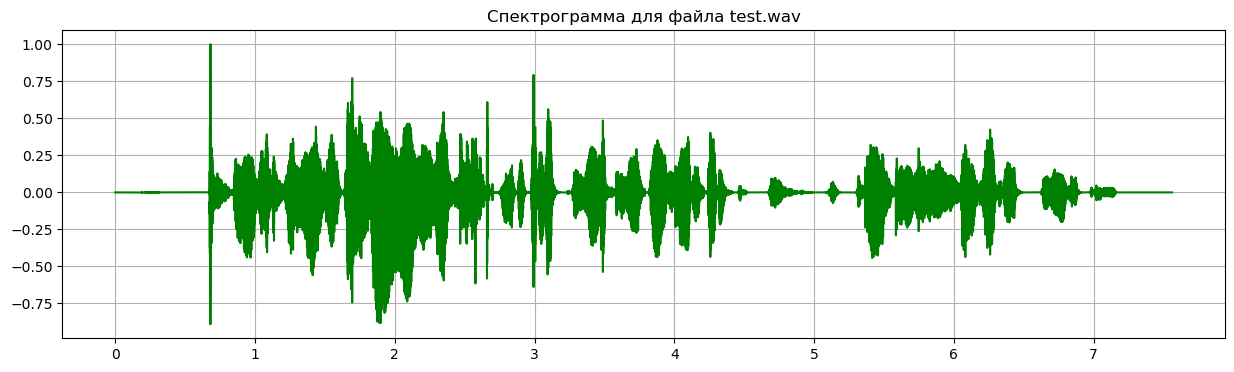

In [36]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.title(f'Спектрограмма для файла {audio_file}')
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio, color='green')
plt.grid(True)

Так как преобразование Фурье создаёт искажения для нестационарных рядов данных, необходимо сделать аудио ряд стационарным. Для этого, разобью его на окна, каждое из которых слишком мало, чтобы быть нестационарным.

In [40]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect') # паддинг для прохождения окном
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [81]:
hop_size = 25 # длинна фрейма в миллисекундах
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print(f'Итоговое количество окон: {audio_framed.shape[0]}, Длинна каждого окна: {audio_framed.shape[1]}')

Итоговое количество окон: 303, Длинна каждого окна: 2048


Визуализирую полученные аудиосигналы

In [82]:
def plot_audio(audio): 
    plt.figure(figsize=(15,4))
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    
    plt.grid()

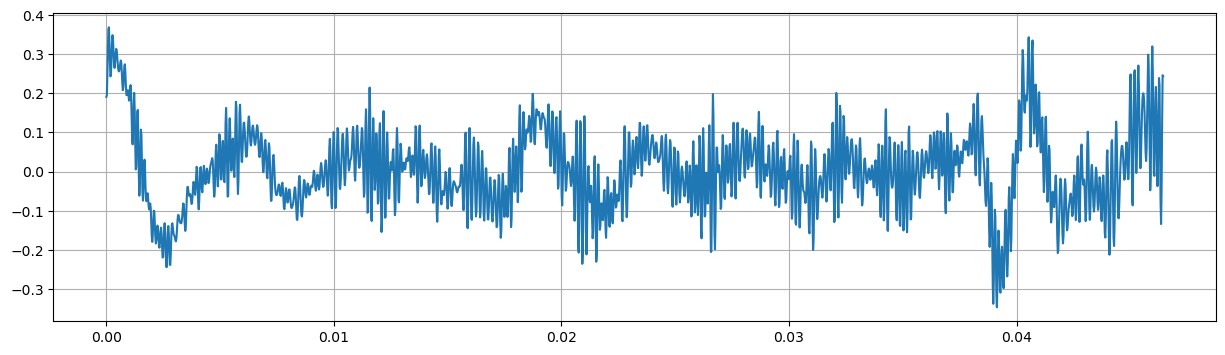

In [83]:
plot_audio(audio_framed[100])

Видно, что каждое окно является внутренней вырезкой из исходного аудиосигнала. Для уменьшения краевых эффектов по время дискретного преобразования Фурье, которое будет описано дальше, а также для фокусировке на локальном содержании фрейма (ведь фреймы, построенные выше, пересекаются, а также дополненны паддингом, то есть каждыйй кусочек сигнала в какой-то момент времени будет центральным в фрейме) используются окна, призванные сгладить аудиоряд к концу записи

Наиболее частые из используемых видов окон это окно Ханнинга и окно Кайзера (которое при параметры beta = 4 идентично окну Ханнинга)

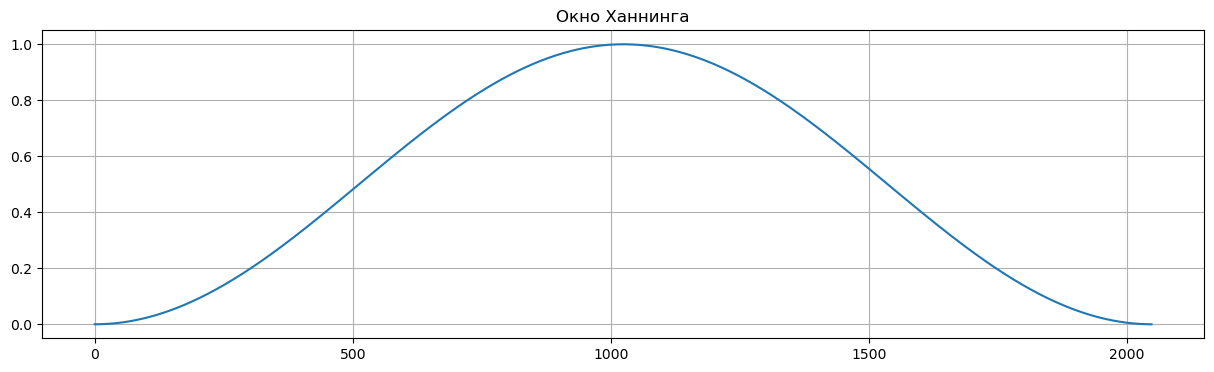

In [84]:
hann_window = get_window("hann", FFT_size)
plt.figure(figsize=(15,4))
plt.title('Окно Ханнинга')
plt.plot(hann_window)
plt.grid()

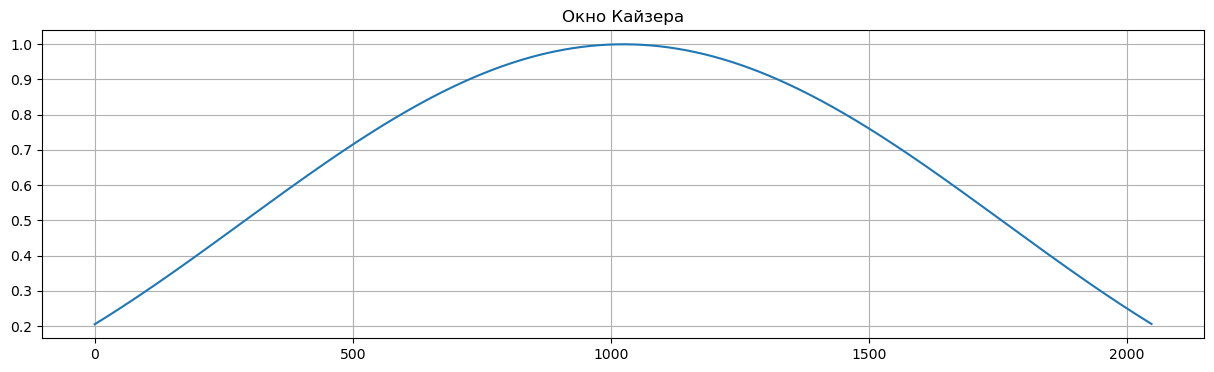

In [85]:
kaiser_window = get_window(("kaiser", 3), FFT_size)
plt.figure(figsize=(15,4))
plt.title('Окно Кайзера')
plt.plot(kaiser_window)
plt.grid()

Окна можно применять последовательно. Выберу окно Ханнинга, так как в нём нет необходимость подбирать гиперпараметр beta

Визуализирую сигнал да и после применения окна

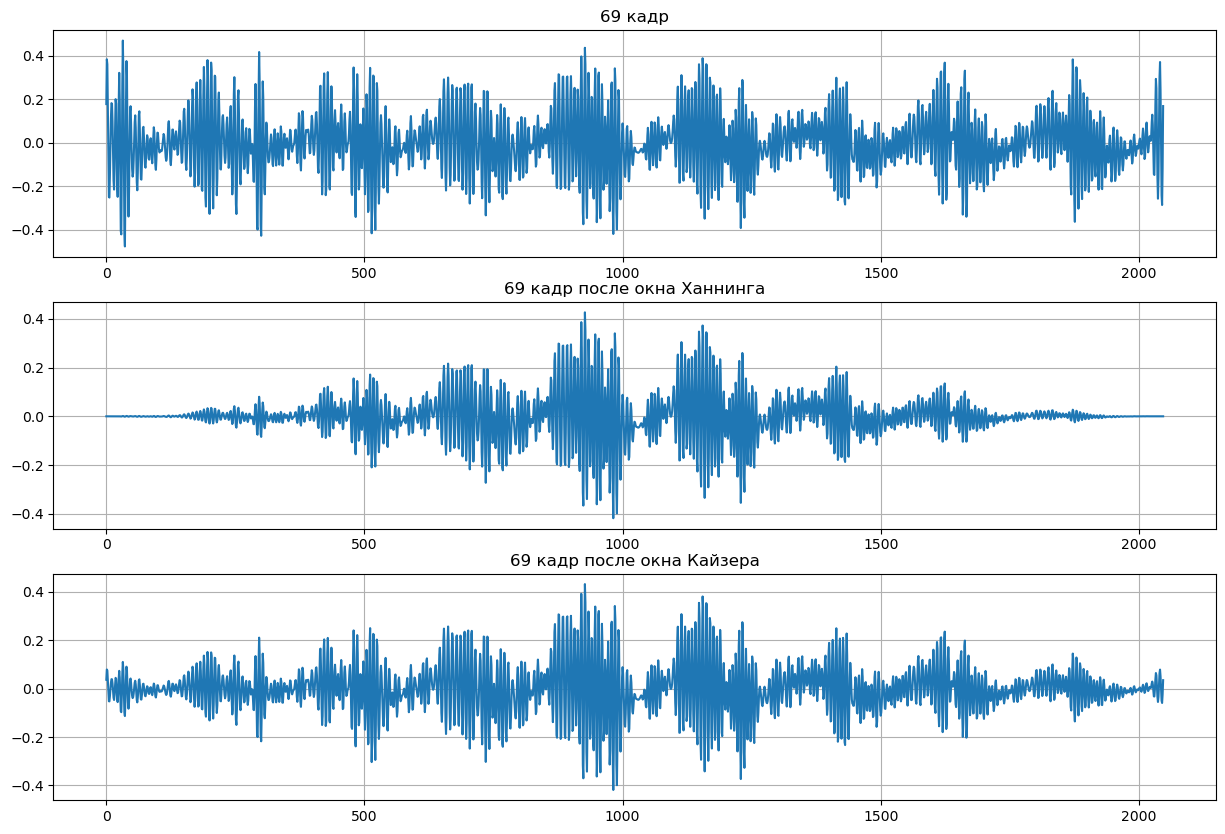

In [86]:
audio_hann = audio_framed * hann_window
audio_kaiser = audio_framed * kaiser_window

ind = 69
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(audio_framed[ind])
plt.title(f'{ind} кадр')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(audio_hann[ind])
plt.title(f'{ind} кадр после окна Ханнинга')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(audio_kaiser[ind])
plt.title(f'{ind} кадр после окна Кайзера')
plt.grid()

### С помощью быстрого преобразования Фурье преобразую полученные фреймы. Длинна окна делится пополам, так как спектр симметричен и отрицательные значения сигнала не несут никакой информации

In [87]:
audio_winT = np.transpose(audio_hann)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

Мощность (необходима для перевода в децибелы) сигнала можно найти следующим образом. В данном контексте мощность это то, как много энергии содержится в каждой частотной компоненте того или иного сигнала

In [171]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(303, 1025)


Для построения мел-кепстральных коэффициентов необходимо также перейти от частоты к мел шкале. Мел шкала - шкала восприятия звуков, построенная на статистической обработке большого числа данных. Мел шкала построена так, чтобы звуки, оценённые по ней, располагались на одинаковом расстоянии друг от друга. В формуле дле вычисления мел используется только частота, хотя доказано, что восприятие звука также зависит также от уровня его громкости и тембра, которые опущены в данной формуле.

Сама формула очень просто и выглядит следующим образом:
<br>
$Mel(freq) = 2595 \cdot log(1 + \frac{freq}{700})$
<br>
$Freq(mel) = 700 \cdot (10^{\frac{mel}{2595}} - 1)$

In [92]:
def freq2mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel2freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

Необходимо получить треугольные фильтры, которые ревномерно распределены по mel шкале. Для этого просто разбиваем мел шкалу на равные участки. Данные фильтры в частотной шкале смешены к более низким частотам.

In [120]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq2mel(fmin)
    fmax_mel = freq2mel(fmax)
    
    print(f'Минимальный MEL: {fmin_mel}')
    print(f'Максимальный MEL: {fmax_mel}')
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel2freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [121]:
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

print(f'Минимальная частота: {freq_min}')
print(f'Максимальная частота: {freq_high}')

filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=sample_rate)
filter_points.shape, mel_freqs.shape

Минимальная частота: 0
Максимальная частота: 22050.0
Минимальный MEL: 0.0
Максимальный MEL: 3923.337321740179


((12,), (12,))

По полученным точкам создаём треугольники, которые имеют возрастающую и убывающую части

In [160]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2, int(FFT_size/2+1))) # половина fft достаточна из-за отсутствия информации в отрицательной части спектра
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n]) # возрастающая часть
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1]) # убывающая часть
    return filters

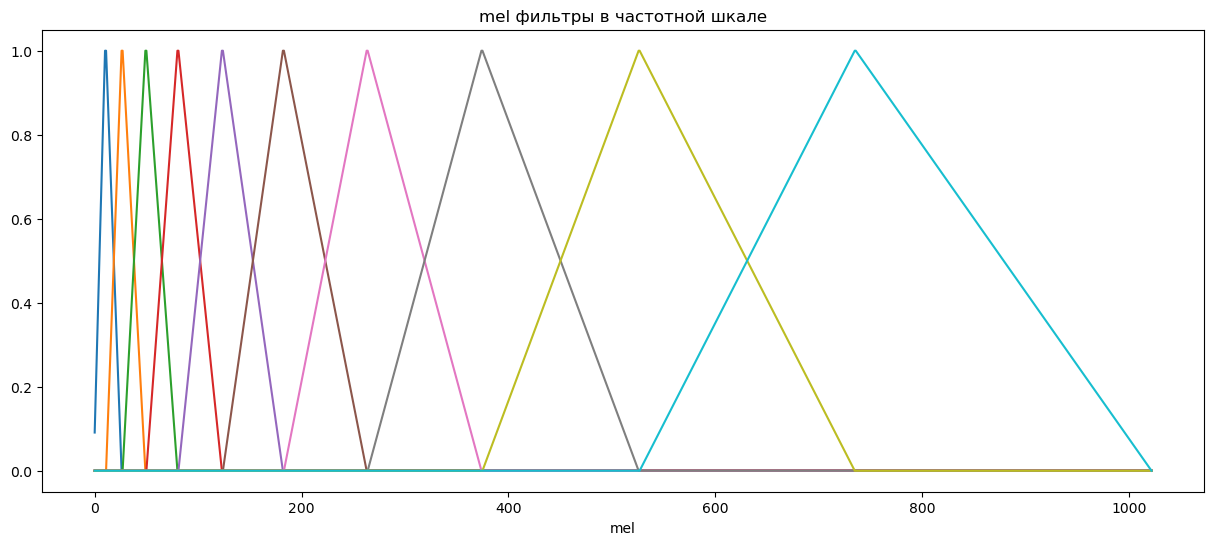

In [161]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15, 6))

for n in range(filters.shape[0]):
    plt.title('mel фильтры в частотной шкале')
    plt.plot(filters[n][1:-1])
    plt.xlabel('mel')

### Нормализация фильтров может помочь, с тем, что количество шума увеличивается с увеличением частоты, ведь на более высокой частоте фильтр растянут и захватывает большой диапазон значений

In [168]:
filters = get_filters(filter_points, FFT_size)
enorm = 2 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num]) # делим на ширину фильтра
filters *= enorm[:, np.newaxis]

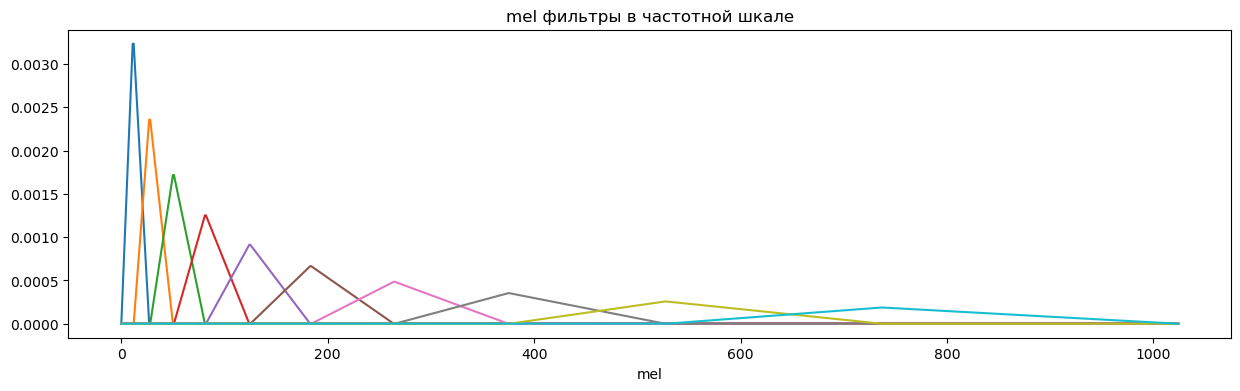

In [167]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.title('mel фильтры в частотной шкале')
    plt.plot(filters[n])
    plt.xlabel('mel')

Перевод в децибелы
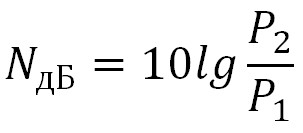

In [169]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

C:\Users\Nikita\AppData\Local\Temp\ipykernel_23144\2531907619.py:2: RuntimeWarning: divide by zero encountered in log10
  audio_log = 10.0 * np.log10(audio_filtered)


(10, 303)

In [170]:
audio_log

array([[-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       ...,
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf],
       [-inf, -inf, -inf, ..., -inf, -inf, -inf]])

https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%BD%D0%BE%D0%B5_%D0%BA%D0%BE%D1%81%D0%B8%D0%BD%D1%83%D1%81%D0%BD%D0%BE%D0%B5_%D0%BF%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5
DCT 3

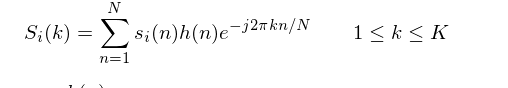

In [23]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [24]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(40, 164)

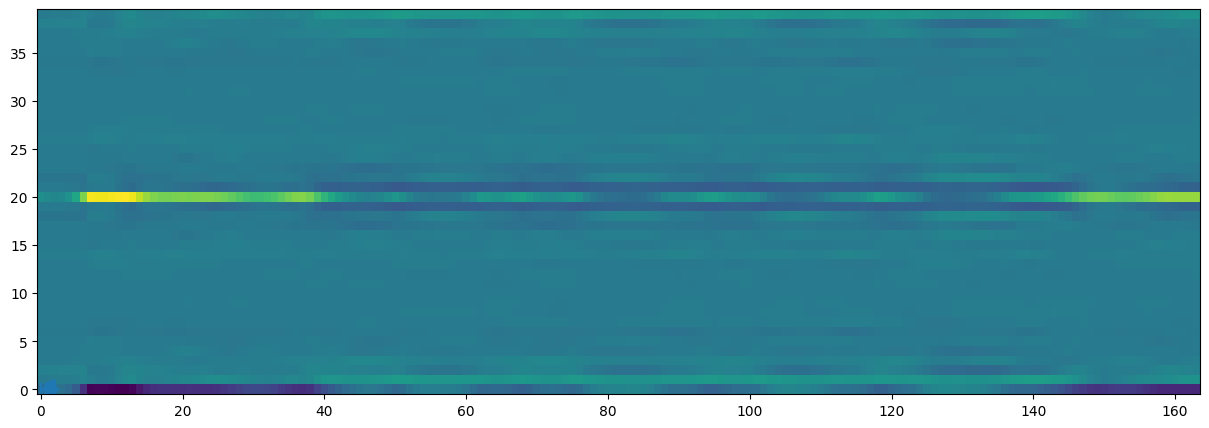

In [25]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');

In [12]:
import librosa

def mfccs_from_file(file_path):
    try:
        audio, sr = librosa.load(file_path, res_type='kaiser_fast')

        if len(audio) == 0:
            raise ValueError(f"Input signal length is too small in file: {file_path}")

        if sr != 22050:
            audio = librosa.resample(audio, sr, 22050, res_type='kaiser_fast')

        mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=20)

        # maxlen = maxlen if maxlen else 256
        # if mfccs.shape[1] > maxlen:
        #     mfccs = mfccs[:, :maxlen]
        # elif mfccs.shape[1] < maxlen:
        #     mfccs = np.pad(mfccs, ((0, 0), (0, maxlen - mfccs.shape[1])), mode='constant')

        return mfccs
    except Exception as e:
        print(e)

In [14]:
def get_mfcc(wav_file_path):
    y, sr = librosa.load(wav_file_path, offset=0, duration=30)
    mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))

    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate( (mfcc_mean, mfcc_min, mfcc_max))

    return mfcc_feature

In [13]:
mfcc_res = mfccs_from_file(audio_file)
mfcc_res.shape

(20, 326)

In [15]:
mfcc_res2 = get_mfcc(audio_file)
mfcc_res2.shape

(60,)